In [27]:
# ============================
# Necessary imports for developing and training
# a Convolutional Neural Network (CNN) with PyTorch
# ============================

# PyTorch: model building, loss functions, and tensor operations
import torch
import torch.nn as nn
import torch.nn.functional as F

# Data handling and DataLoaders
from torch.utils.data import DataLoader, random_split

# Image loading, preprocessing, and visualization (datasets, transforms, utilities)
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

# Scientific computing and data manipulation
import numpy as np
import pandas as pd

# Model evaluation (confusion matrix)
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# File download, extraction, and management
import urllib.request
import zipfile
import os
from pathlib import Path
import subprocess
import json

# Utilities
import random


In [ ]:
# ============================
# Mount Google Drive to access dataset files
# ============================

from google.colab import drive
drive.mount('/content/drive')  # Mounts the drive to /content/drive


In [ ]:
# ============================
# List the contents of the dataset folder
# ============================

!ls /content/drive/MyDrive/fichier_pour_data_set  # Check dataset files


In [ ]:
# ============================
# Unzip the dataset into a working directory
# ============================

!unzip -q "/content/drive/MyDrive/fichier_pour_data_set/data_set.zip" -d "/content/data_set"

# List the contents to verify extraction
!ls "/content/data_set"


In [ ]:
# ============================
# List the images inside the main dataset folder
# ============================

!ls data_set/cell_images  # Should show class subfolders like 'Parasitized' and 'Uninfected'


In [ ]:
# ============================
# Image transformations for preprocessing
# ============================

transform = transforms.Compose([
    transforms.Resize((128, 128)),           # Resize all images to 128x128
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
    transforms.Normalize([0.5, 0.5, 0.5],    # Normalize per channel (R, G, B)
                         [0.5, 0.5, 0.5])
])

# ============================
# Load the dataset using ImageFolder
# ============================

dataset = datasets.ImageFolder(
    root="data_set/cell_images",  # Path to the folder containing class subfolders
    transform=transform           # Apply the transformations defined above
)

# ============================
# Create a DataLoader for batching and shuffling
# ============================

loader = DataLoader(
    dataset,
    batch_size=64,   # Larger batch size reduces number of iterations per epoch
    shuffle=True,     # Shuffle data to improve training
    num_workers=8,    # Number of parallel data loading workers
    pin_memory=True   # Faster transfer to GPU if available
)

# Display classes and their corresponding indices
print("Classes:", dataset.class_to_idx)  # Example: {'Parasitized': 0, 'Uninfected': 1}


In [ ]:
# ============================
# Get one batch from the DataLoader
# ============================

images, labels = next(iter(loader))  # Retrieve a single batch
print("Shape of images:", images.shape)   # Expected: [64, 3, 128, 128]
print("Labels of the batch (first 10):", labels[:10])  # Show first 10 labels
print("Shape of the first image:", images[0].shape)
print("Pixel value range:", images.min(), images.max())  # Check normalization


Shape of images: torch.Size([64, 3, 128, 128])
Labels of the batch (first 10): tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0])
Shape of the first image: torch.Size([3, 128, 128])
Pixel value range: tensor(-1.) tensor(0.8431)


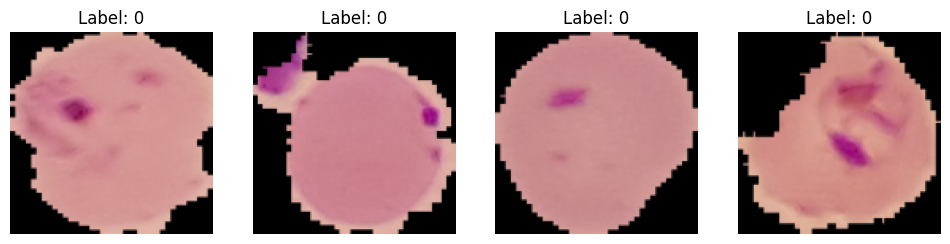

In [ ]:
# ============================
# Visualize a few images from the batch
# ============================

# Create a figure with 1 row and 4 columns to display 4 images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    # Convert image from tensor (C,H,W) to (H,W,C) for matplotlib
    img = images[i].numpy().transpose(1, 2, 0)

    # Denormalize the image to display properly
    img = (img * 0.5) + 0.5

    # Display the image
    axes[i].imshow(img)

    # Show the label of the image
    axes[i].set_title(f"Label: {labels[i].item()}")

    # Remove axes for cleaner visualization
    axes[i].axis('off')

# Display the figure
plt.show()


In [ ]:
# ============================
# Inspect the dataset object
# ============================

dataset  # Display dataset info (ImageFolder object)


Dataset ImageFolder
    Number of datapoints: 27558
    Root location: data_set/cell_images
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [28]:
loader

In [29]:
# ============================
# Get another batch to verify shapes and normalization
# ============================

images, labels = next(iter(loader))
print("Batch shape:", images.shape)       # Expected: [64, 3, 128, 128]
print("First 10 labels:", labels[:10])
print("First image shape:", images[0].shape)
print("Pixel value range:", images.min(), images.max())  # Should be normalized between -1 and 1


Batch shape: torch.Size([64, 3, 128, 128])
First 10 labels: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1])
First image shape: torch.Size([3, 128, 128])
Pixel value range: tensor(-1.) tensor(0.9294)


In [30]:
# ============================
# Quick test to check class distribution in the dataset
# ============================

# Extract all labels from the dataset
all_labels = [label for _, label in dataset]   # Get all labels
all_labels = torch.tensor(all_labels)          # Convert to tensor for easier operations

# Count how many images belong to each class
print("Parasitized :", (all_labels == 0).sum().item())
print("Uninfected :", (all_labels == 1).sum().item())


Parasitized : 13779
Uninfected : 13779


In [31]:
# ============================
# Quick test of a convolutional layer
# ============================

conv = nn.Conv2d(3, 16, 3, 1, 1)  # Conv2d: 3 input channels → 16 output filters, kernel 3x3, stride=1, padding=1
out = conv(images)                # Apply convolution on a batch of images
print("Output shape after conv:", out.shape)  # Expected: [batch_size, 16, 128, 128]


Output shape after conv: torch.Size([64, 16, 128, 128])


In [32]:
# ============================
# Split the dataset into train, validation, and test sets
# ============================

total_size = len(dataset)                   # Total number of images
train_size = int(0.7 * total_size)         # 70% for training
val_size   = int(0.15 * total_size)        # 15% for validation
test_size  = total_size - train_size - val_size  # Remaining 15% for test

# Create the subsets
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)

# ============================
# Create DataLoaders for batch processing
# ============================

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

# Display number of batches for each subset
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


Train batches: 302, Val batches: 65, Test batches: 65


In [33]:

# ============================
# CNN model for malaria classification
# ============================

class MalariaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(MalariaCNN, self).__init__()

        # --- Block 1: Conv + BatchNorm + ReLU + MaxPool + Dropout ---
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.2)

        # --- Block 2: Conv + BatchNorm + ReLU + MaxPool + Dropout ---
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.2)

        # --- Block 3: Conv + BatchNorm + ReLU + MaxPool + Dropout ---
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.2)

        # --- Fully Connected Layers ---
        # Flatten after pooling: 64 * 16 * 16
        self.fc1 = nn.Linear(64 * 16 * 16, 384)  # slightly smaller
        self.dropout = nn.Dropout(0.5)           # original dropout
        self.fc2 = nn.Linear(384, num_classes)

    def forward(self, x):
        # --- Block 1 ---
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # --- Block 2 ---
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # --- Block 3 ---
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.drop3(x)

        # --- Flatten ---
        x = x.view(x.size(0), -1)

        # --- Fully Connected ---
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # raw logits

        return x


In [34]:
# ============================
# Instantiate the model and do a quick test
# ============================

model = MalariaCNN(num_classes=2)
print(model)

# Optional: test a batch if 'images' exists
# images, labels = next(iter(loader))
# outputs = model(images)
# print(outputs.shape)  # Should be [batch_size, 2]


MalariaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=384, bias=True)
  (dropout): Dropout(p=0.5, inplace=Fals

In [35]:
# ============================
# Define the loss function and optimizer
# ============================

# Loss function for multi-class classification (here binary)
criterion = torch.nn.CrossEntropyLoss()

# Adam optimizer to update model weights
# lr=0.001: learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [37]:
# ============================
# Set device (GPU if available, else CPU)
# ============================

print("Current device of model parameters:", next(model.parameters()).device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

# Comment:
# This allows using GPU to accelerate training if available.


Current device of model parameters: cuda:0


MalariaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=384, bias=True)
  (dropout): Dropout(p=0.5, inplace=Fals

In [41]:
import time

epochs = 10

# ============================
# Lists to track performance
# ============================
train_losses = []   # average loss per epoch (train)
train_correct = []  # number of correct predictions (train)
val_losses = []     # average loss per epoch (validation)
val_correct = []    # number of correct predictions (validation)

# ============================
# Lists to track model weights
# ============================
conv1_weights = []
conv2_weights = []
conv3_weights = []
fc1_weights   = []
fc2_weights   = []

start_time = time.time()

for epoch in range(epochs):
    trn_corr = 0
    trn_loss_epoch = 0
    model.train()  # enable dropout for regularization

    # ============================
    # Training loop
    # ============================
    for b, (X_train, Y_train) in enumerate(train_loader, 1):
        X_train, Y_train = X_train.to(device), Y_train.to(device)

        # Forward pass + loss
        y_pred = model(X_train)
        loss = criterion(y_pred, Y_train)
        trn_loss_epoch += loss.item() * X_train.size(0)  # accumulate for average

        # Backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Batch accuracy
        predicted = torch.max(y_pred, 1)[1]
        trn_corr += (predicted == Y_train).sum().item()

        if b % 300 == 0:  # adjust frequency based on batch size
            print(f"Epoch: {epoch} | Batch: {b} | Loss: {loss.item():.4f}")

    # Average training loss for epoch
    avg_trn_loss = trn_loss_epoch / len(train_dataset)
    train_losses.append(avg_trn_loss)
    train_correct.append(trn_corr)

    # ============================
    # Store model weights
    # ============================
    conv1_weights.append(model.conv1.weight.detach().cpu().numpy().copy())
    conv2_weights.append(model.conv2.weight.detach().cpu().numpy().copy())
    conv3_weights.append(model.conv3.weight.detach().cpu().numpy().copy())
    fc1_weights.append(model.fc1.weight.detach().cpu().numpy().copy())
    fc2_weights.append(model.fc2.weight.detach().cpu().numpy().copy())

    # ============================
    # Validation
    # ============================
    val_corr = 0
    val_loss_epoch = 0
    model.eval()  # disable dropout for validation
    with torch.no_grad():
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            y_val_pred = model(X_val)
            val_loss_epoch += criterion(y_val_pred, Y_val).item() * X_val.size(0)
            predicted = torch.max(y_val_pred, 1)[1]
            val_corr += (predicted == Y_val).sum().item()

    avg_val_loss = val_loss_epoch / len(val_dataset)
    val_losses.append(avg_val_loss)
    val_correct.append(val_corr)

    # Overfitting indicator (train vs validation accuracy)
    overfit_gap = (train_correct[-1]/len(train_dataset) - val_correct[-1]/len(val_dataset)) * 100

    print(f"Epoch {epoch} | "
          f"Train Loss: {avg_trn_loss:.4f}, Train Acc: {train_correct[-1]/len(train_dataset):.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_correct[-1]/len(val_dataset):.4f} | "
          f"Overfit Gap: {overfit_gap:.2f}%")

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")


Epoch: 0 | Batch: 300 | Loss: 0.0981
Epoch 0 | Train Loss: 0.1393, Train Acc: 0.9552 | Val Loss: 0.1470, Val Acc: 0.9540 | Overfit Gap: 0.11%
Epoch: 1 | Batch: 300 | Loss: 0.0894
Epoch 1 | Train Loss: 0.1311, Train Acc: 0.9566 | Val Loss: 0.1400, Val Acc: 0.9555 | Overfit Gap: 0.11%
Epoch: 2 | Batch: 300 | Loss: 0.0571
Epoch 2 | Train Loss: 0.1304, Train Acc: 0.9557 | Val Loss: 0.1431, Val Acc: 0.9538 | Overfit Gap: 0.19%
Epoch: 3 | Batch: 300 | Loss: 0.0780
Epoch 3 | Train Loss: 0.1237, Train Acc: 0.9584 | Val Loss: 0.1432, Val Acc: 0.9567 | Overfit Gap: 0.17%
Epoch: 4 | Batch: 300 | Loss: 0.2397
Epoch 4 | Train Loss: 0.1283, Train Acc: 0.9570 | Val Loss: 0.1435, Val Acc: 0.9564 | Overfit Gap: 0.06%
Epoch: 5 | Batch: 300 | Loss: 0.0736
Epoch 5 | Train Loss: 0.1265, Train Acc: 0.9570 | Val Loss: 0.1468, Val Acc: 0.9543 | Overfit Gap: 0.27%
Epoch: 6 | Batch: 300 | Loss: 0.1037
Epoch 6 | Train Loss: 0.1208, Train Acc: 0.9590 | Val Loss: 0.1532, Val Acc: 0.9560 | Overfit Gap: 0.31%
Epoch:

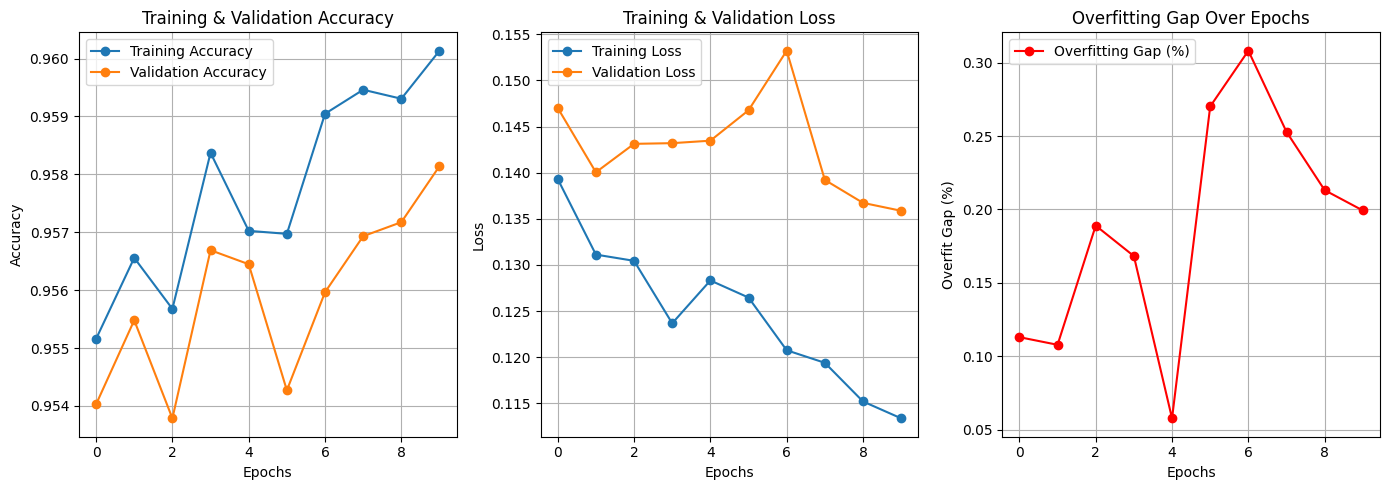

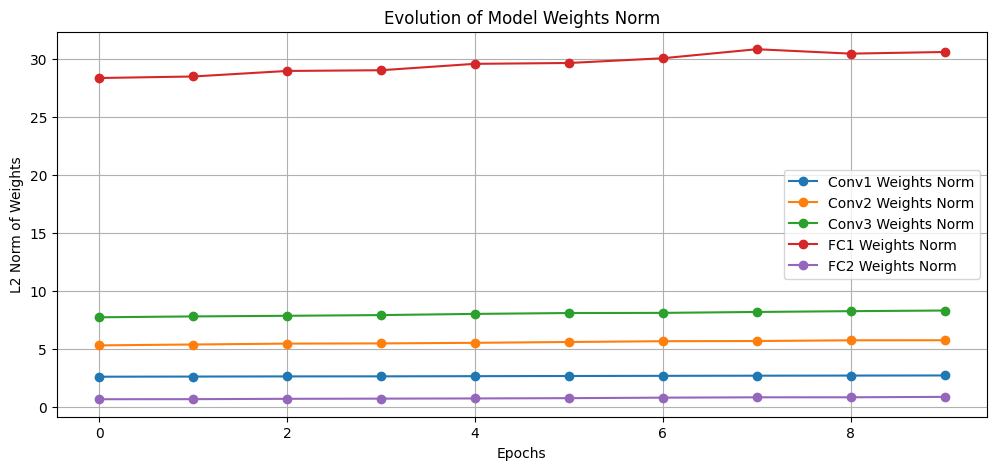

In [43]:
# ============================
# Visualize performance and weight evolution
# ============================
# This block plots:
# 1) Training & validation loss and accuracy over epochs
# 2) L2 norms of main model weights
# 3) Overfitting gap per epoch (train_acc - val_acc)

# Compute accuracy as a fraction
train_acc = [x/len(train_dataset) for x in train_correct]
val_acc   = [x/len(val_dataset) for x in val_correct]

# Compute overfitting gap (%)
overfit_gap = [abs((ta - va))*100 for ta, va in zip(train_acc, val_acc)]

# ============================
# Plot Loss and Accuracy curves
# ============================
plt.figure(figsize=(14,5))

# Accuracy subplot
plt.subplot(1,3,1)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1,3,2)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Overfitting gap subplot
plt.subplot(1,3,3)
plt.plot(overfit_gap, label='Overfitting Gap (%)', marker='o', color='r')
plt.xlabel('Epochs')
plt.ylabel('Overfit Gap (%)')
plt.title('Overfitting Gap Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ============================
# Function to compute L2 norms of weights
# ============================
def compute_weight_norm(weights_list):
    """Compute L2 norm of weights for each epoch"""
    norms = [np.linalg.norm(w) for w in weights_list]
    return norms

# ============================
# Plot weight norms evolution
# ============================
plt.figure(figsize=(12,5))
plt.plot(compute_weight_norm(conv1_weights), label='Conv1 Weights Norm', marker='o')
plt.plot(compute_weight_norm(conv2_weights), label='Conv2 Weights Norm', marker='o')
plt.plot(compute_weight_norm(conv3_weights), label='Conv3 Weights Norm', marker='o')
plt.plot(compute_weight_norm(fc1_weights), label='FC1 Weights Norm', marker='o')
plt.plot(compute_weight_norm(fc2_weights), label='FC2 Weights Norm', marker='o')

plt.xlabel('Epochs')
plt.ylabel('L2 Norm of Weights')
plt.title('Evolution of Model Weights Norm')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Evaluate on the test set after training
model.eval()
test_corr = 0
test_loss_total = 0
with torch.no_grad():
    for X_test, Y_test in test_loader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        y_test_pred = model(X_test)
        test_loss_total += criterion(y_test_pred, Y_test).item() * X_test.size(0)
        predicted = torch.argmax(y_test_pred, 1)
        test_corr += (predicted == Y_test).sum().item()

avg_test_loss = test_loss_total / len(test_dataset)
test_acc = test_corr / len(test_dataset)

print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_acc*100:.2f}%")


Test Loss: 0.1377 | Test Accuracy: 95.26%


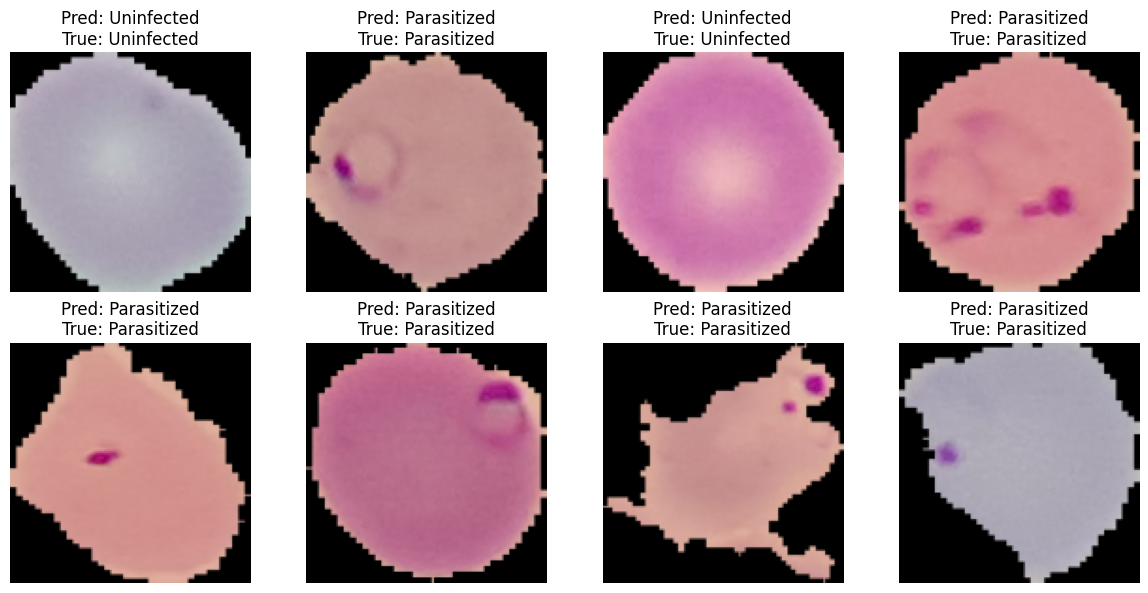

In [45]:
# ============================
# Set the model to evaluation mode
# ============================
# Disables dropout and batchnorm for testing
model.eval()

# ============================
# Get a batch from the test_loader
# ============================
X_batch, Y_batch = next(iter(test_loader))       # fetch a batch of images and labels
X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # move to GPU if available

# ============================
# Make predictions
# ============================
with torch.no_grad():        # no gradient computation for faster inference
    y_pred = model(X_batch)  # output logits
    predicted = torch.max(y_pred, 1)[1]  # predicted class indices

# ============================
# Get class names
# ============================
classes = dataset.classes  # ['Parasitized', 'Uninfected']

# ============================
# Display some images with their predictions
# ============================
plt.figure(figsize=(12,6))
for i in range(8):  # display 8 examples
    plt.subplot(2,4,i+1)
    img = X_batch[i].cpu().permute(1,2,0)  # (C,H,W) -> (H,W,C) for matplotlib
    img = img * 0.5 + 0.5                 # denormalize for correct display
    plt.imshow(img)
    plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[Y_batch[i]]}")  # title with prediction and true label
    plt.axis('off')

plt.tight_layout()
plt.show()


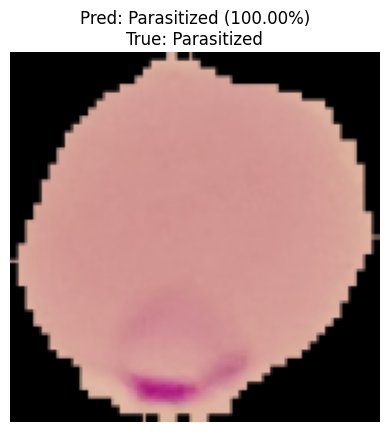

In [46]:
#--------------------------------------------------------
# Playing with the model by taking a random test image
#--------------------------------------------------------
model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm)

# Choose a random index from the test dataset
idx = random.randint(0, len(test_dataset) - 1)
img, label = test_dataset[idx]

# Add batch dimension and move to device
img_batch = img.unsqueeze(0).to(device)

# Make prediction
with torch.no_grad():  # No gradient calculation for inference
    outputs = model(img_batch)
    probs = torch.softmax(outputs, dim=1)       # Convert logits to probabilities
    predicted_class = torch.argmax(probs, dim=1).item()
    predicted_prob = probs[0][predicted_class].item()

# Class names
classes = dataset.classes  # ['Parasitized', 'Uninfected']

# Display the image with prediction and true label
plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize for display
plt.title(f"Pred: {classes[predicted_class]} ({predicted_prob*100:.2f}%)\nTrue: {classes[label]}")
plt.axis('off')
plt.show()


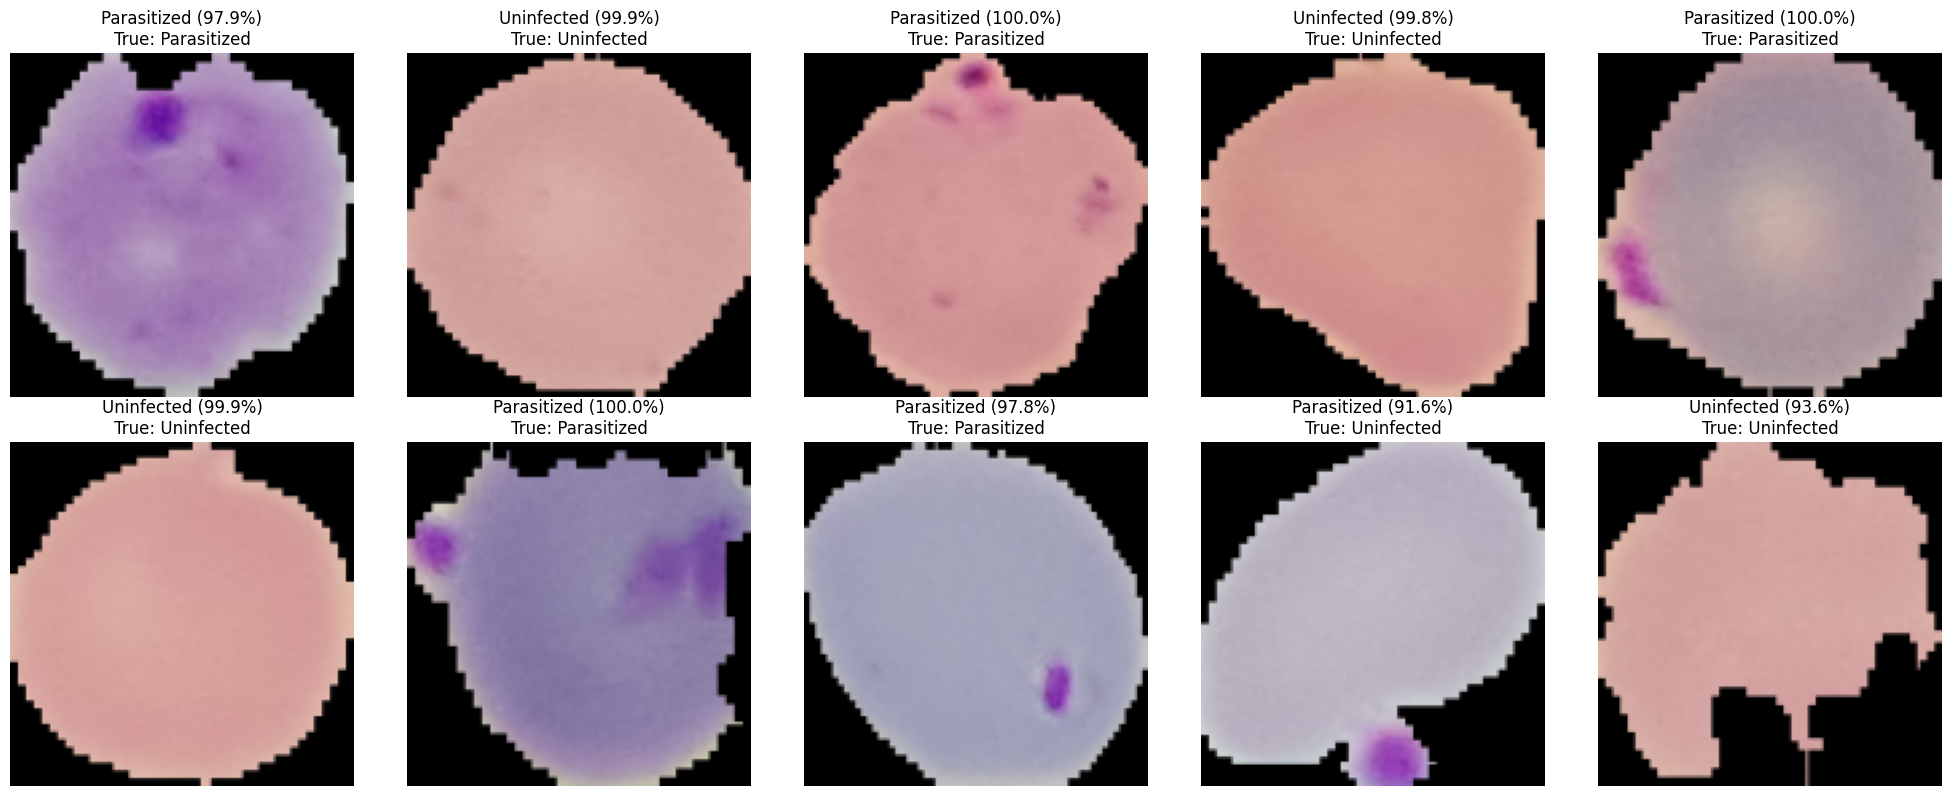

In [47]:
# Playing with the model on multiple random test images
model.eval()  # Set model to evaluation mode

# Class names
classes = dataset.classes  # ['Parasitized', 'Uninfected']

plt.figure(figsize=(20, 8))

for i in range(10):
    # Choose a random index from the test dataset
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]

    # Add batch dimension and move to device
    img_batch = img.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():  # no gradient computation
        outputs = model(img_batch)
        probs = torch.softmax(outputs, dim=1)  # convert logits to probabilities
        predicted_class = torch.argmax(probs, dim=1).item()
        predicted_prob = probs[0][predicted_class].item()

    # Display image with prediction and true label
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize for display
    plt.title(f"{classes[predicted_class]} ({predicted_prob*100:.1f}%)\nTrue: {classes[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [48]:
for name, param in model.named_parameters():
    print(f"{name:30} | shape={tuple(param.shape)} | requires_grad={param.requires_grad}")


conv1.weight                   | shape=(16, 3, 3, 3) | requires_grad=True
conv1.bias                     | shape=(16,) | requires_grad=True
bn1.weight                     | shape=(16,) | requires_grad=True
bn1.bias                       | shape=(16,) | requires_grad=True
conv2.weight                   | shape=(32, 16, 3, 3) | requires_grad=True
conv2.bias                     | shape=(32,) | requires_grad=True
bn2.weight                     | shape=(32,) | requires_grad=True
bn2.bias                       | shape=(32,) | requires_grad=True
conv3.weight                   | shape=(64, 32, 3, 3) | requires_grad=True
conv3.bias                     | shape=(64,) | requires_grad=True
bn3.weight                     | shape=(64,) | requires_grad=True
bn3.bias                       | shape=(64,) | requires_grad=True
fc1.weight                     | shape=(384, 16384) | requires_grad=True
fc1.bias                       | shape=(384,) | requires_grad=True
fc2.weight                     | shape=(2,

In [49]:
for name, param in model.named_parameters():
    print(f"{name:30} | "
          f"mean={param.mean().item():.6f} | "
          f"std={param.std().item():.6f} | "
          f"min={param.min().item():.6f} | "
          f"max={param.max().item():.6f}")


conv1.weight                   | mean=0.002967 | std=0.130204 | min=-0.334091 | max=0.377414
conv1.bias                     | mean=0.000003 | std=0.000220 | min=-0.000392 | max=0.000379
bn1.weight                     | mean=0.761103 | std=0.104401 | min=0.611934 | max=0.943605
bn1.bias                       | mean=-0.402532 | std=0.221615 | min=-1.010651 | max=-0.133373
conv2.weight                   | mean=-0.019423 | std=0.082290 | min=-0.321938 | max=0.386036
conv2.bias                     | mean=0.000004 | std=0.000019 | min=-0.000035 | max=0.000052
bn2.weight                     | mean=0.764136 | std=0.154304 | min=0.495922 | max=1.039127
bn2.bias                       | mean=-0.350356 | std=0.111023 | min=-0.642833 | max=-0.089279
conv3.weight                   | mean=-0.010550 | std=0.060234 | min=-0.268217 | max=0.271964
conv3.bias                     | mean=-0.000001 | std=0.000010 | min=-0.000036 | max=0.000026
bn3.weight                     | mean=0.641496 | std=0.169763 | m

In [65]:
print(model.conv1.weight[0, 0, :5, :5])  # first filter, first channel


tensor([[ 0.1185, -0.1116,  0.1052],
        [-0.0072, -0.0924, -0.0611],
        [ 0.1767,  0.0201,  0.1784]], grad_fn=<SelectBackward0>)


In [70]:
# Save ONLY the model parameters (state_dict)
torch.save(model.state_dict(), 'malaria_cnn_parameters.pth')
print("✅ Model parameters saved: malaria_cnn_parameters.pth")

✅ Model parameters saved: malaria_cnn_parameters.pth


In [73]:
import os

# List all .pth files in current Colab directory
print("📁 Checking current directory:")
!ls -la *.pth 2>/dev/null || echo "No .pth files found here"

# Check common locations
paths_to_check = [
    '/content/',
    '/content/drive/MyDrive/',
    '/content/drive/MyDrive/Colab Notebooks/',
    os.getcwd()  # Current working directory
]

print("\n🔍 Searching for model files...")
for path in paths_to_check:
    if os.path.exists(path):
        print(f"\nChecking: {path}")
        !find "$path" -name "*.pth" -type f 2>/dev/null | head -5

📁 Checking current directory:
-rw-r--r-- 1 root root 75821033 Dec 29 10:50 malaria_cnn_checkpoint.pth
-rw-r--r-- 1 root root      719 Dec 29 10:47 malaria_cnn_full_model.pth
-rw-r--r-- 1 root root 25275305 Dec 29 10:51 malaria_cnn_parameters.pth
-rw-r--r-- 1 root root 25275148 Dec 29 10:50 malaria_cnn_weights.pth

🔍 Searching for model files...

Checking: /content/
/content/malaria_cnn_weights.pth
/content/malaria_cnn_checkpoint.pth
/content/malaria_cnn_parameters.pth
/content/malaria_cnn_full_model.pth

Checking: /content/drive/MyDrive/

Checking: /content/drive/MyDrive/Colab Notebooks/

Checking: /content
/content/malaria_cnn_weights.pth
/content/malaria_cnn_checkpoint.pth
/content/malaria_cnn_parameters.pth
/content/malaria_cnn_full_model.pth


In [74]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define target directory on Drive
target_dir = '/content/drive/MyDrive/malaria_models/'
os.makedirs(target_dir, exist_ok=True)

# List of your model files
model_files = [
    'malaria_cnn_parameters.pth',    # 25MB - Most important (weights only)
    'malaria_cnn_weights.pth',       # 25MB - Same as above
    'malaria_cnn_checkpoint.pth',    # 76MB - For resuming training
    'malaria_cnn_full_model.pth',    # 719B - Probably corrupted (too small)
]

# Copy each file to Google Drive
for file in model_files:
    if os.path.exists(file):
        src = file
        dst = os.path.join(target_dir, file)
        shutil.copy2(src, dst)
        size_mb = os.path.getsize(src) / (1024 * 1024)
        print(f"✅ Saved: {file} ({size_mb:.1f} MB) → {target_dir}")
    else:
        print(f"⚠️  Missing: {file}")

print(f"\n📁 All models saved to: {target_dir}")

# Verify
print("\n🔍 Files on Google Drive:")
!ls -la "/content/drive/MyDrive/malaria_models/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved: malaria_cnn_parameters.pth (24.1 MB) → /content/drive/MyDrive/malaria_models/
✅ Saved: malaria_cnn_weights.pth (24.1 MB) → /content/drive/MyDrive/malaria_models/
✅ Saved: malaria_cnn_checkpoint.pth (72.3 MB) → /content/drive/MyDrive/malaria_models/
✅ Saved: malaria_cnn_full_model.pth (0.0 MB) → /content/drive/MyDrive/malaria_models/

📁 All models saved to: /content/drive/MyDrive/malaria_models/

🔍 Files on Google Drive:
total 123411
-rw------- 1 root root 75821033 Dec 29 10:50 malaria_cnn_checkpoint.pth
-rw------- 1 root root      719 Dec 29 10:47 malaria_cnn_full_model.pth
-rw------- 1 root root 25275305 Dec 29 10:51 malaria_cnn_parameters.pth
-rw------- 1 root root 25275148 Dec 29 10:50 malaria_cnn_weights.pth
